In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from config import get_default_cfg
from sae import VanillaSAE, TopKSAE, BatchTopKSAE, JumpReLUSAE
import transformer_lens
from transformer_lens import HookedTransformer, HookedEncoder
from transformers import GPT2Tokenizer, GPT2Model, BertModel, BertTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import json
import os
import numpy as np

D:\Escritorio\PythonProyects\SparseAutoencodersTFM\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
### GPT2-SMALL BATCHTOPK SAE ANALYSIS

In [2]:
run = wandb.init()
artifact = run.use_artifact('ybiku-unir/SAE_GPT2-small/gpt2-small_blocks.11.hook_resid_pre_6144_batchtopk_32_0.0003_48827:v0', type='model')
artifact_dir = artifact.download()

config_path = os.path.join(artifact_dir, 'config.json')
with open(config_path, 'r') as f:
    config = json.load(f)

if "dtype" in config and isinstance(config["dtype"], str):
    if config["dtype"] == "torch.float32":
        config["dtype"] = torch.float32
    elif config["dtype"] == "torch.float16":
        config["dtype"] = torch.float16

sae = BatchTopKSAE(config).to(config["device"])
sae.load_state_dict(torch.load(os.path.join(artifact_dir, 'sae.pt')))
sae.eval()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ybiku (ybiku-unir) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   2 of 2 files downloaded.  


BatchTopKSAE()

In [7]:
def hook_fn(act, hook):
    activation[hook.name] = act.detach()
    return act

model = HookedTransformer.from_pretrained("gpt2-small").to(config["device"])
hook_point = config["hook_point"]
feature_count = torch.ones(config["dict_size"], device=config["device"])
num_examples = 0
top_examples_per_feature = {i: [] for i in range(config["dict_size"])}

dataset = load_dataset("EleutherAI/the_pile_deduplicated", split="train", streaming=True)
dataset = dataset.shuffle(seed=config["seed"]).take(int(1e4))

for example in dataset:
    num_examples += 1
    text = example['text']
    tokens = model.to_tokens(text, truncate=True, move_to_device=True, prepend_bos=True).squeeze(0)
    if tokens.shape[0] > config["seq_len"]:
        tokens = tokens[:config["seq_len"]]
    elif tokens.shape[0] < config["seq_len"]:
        tokens = F.pad(tokens, (0, config["seq_len"] - tokens.shape[0]), value=model.tokenizer.pad_token_id)

    activation = {}
    with torch.no_grad():
        _ = model.run_with_hooks(
            tokens,
            fwd_hooks=[(hook_point, hook_fn)]
        )
    activations = activation[hook_point]
    batch_activations = activations.reshape(-1, config["act_size"]).to(config["device"])
    with torch.no_grad():
        sae_output = sae(batch_activations)

    feature_acts = sae_output["feature_acts"]
    max_activations, _ = torch.max(feature_acts, dim=0)

    feature_activations_token = (sae_output["feature_acts"] > 0)
    feature_activations_example = feature_activations_token.any(dim=0).int()
    feature_count += feature_activations_example

    for feature_idx in range(config["dict_size"]):
        activation_val = max_activations[feature_idx].item()
        if activation_val > 0:  # Solo guardar si hay activación
            # Guardar temporalmente todos los ejemplos
            top_examples_per_feature[feature_idx].append((activation_val, text))
            # Mantenemos ordenada la lista por valor de activación (descendente)
            top_examples_per_feature[feature_idx].sort(key=lambda x: x[0], reverse=True)
            # Mantenemos solo los 20 mejores ejemplos
            if len(top_examples_per_feature[feature_idx]) > 20:
                top_examples_per_feature[feature_idx] = top_examples_per_feature[feature_idx][:20]


feature_prob = feature_count / num_examples
feature_activation_pct = 100 * feature_prob

vals = feature_activation_pct.cpu().numpy()
num_features = len(vals)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


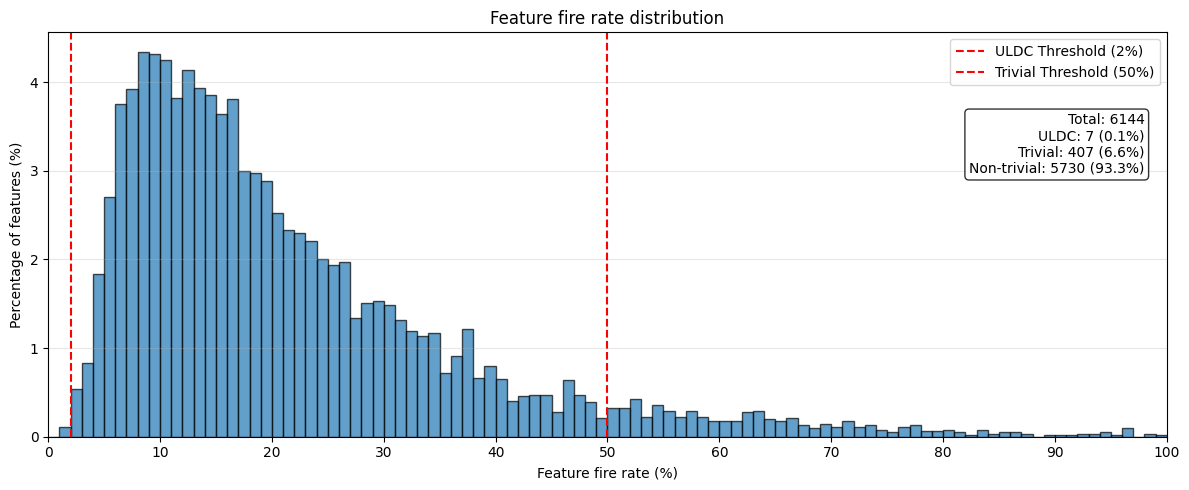

In [8]:
uldc_thresh = 2
trivial_thresh = 50
uldc_features = (feature_activation_pct < uldc_thresh).sum().item()
trivial_features = (feature_activation_pct > trivial_thresh).sum().item()
useful_features = num_features - uldc_features - trivial_features


counts, bins = np.histogram(vals, bins=100, range=(0,100))
counts_pct = (counts / num_features) * 100
bin_width = bins[1] - bins[0]
plt.figure(figsize=(12, 5))
plt.bar(
    bins[:-1],
    counts_pct,
    width=bin_width,
    align='edge',
    edgecolor='black',
    alpha=0.7
)
info_text = f"Total: {num_features}\nULDC: {uldc_features} ({uldc_features/num_features*100:.1f}%)\nTrivial: {trivial_features} ({trivial_features/num_features*100:.1f}%)\nNon-trivial: {useful_features} ({useful_features/num_features*100:.1f}%)"
plt.text(
    0.98, 0.80, info_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
plt.axvline(x=uldc_thresh, color='red', linestyle='--', label=f'ULDC Threshold ({uldc_thresh}%)')
plt.axvline(x=trivial_thresh, color='red', linestyle='--', label=f'Trivial Threshold ({trivial_thresh}%)')
plt.xlabel('Feature fire rate (%)')
plt.ylabel('Percentage of features (%)')
plt.title('Feature fire rate distribution')
plt.grid(axis='y', alpha=0.3)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

In [9]:
for feature_idx in range(config["dict_size"]):
    activation_probability = feature_prob[feature_idx].item()
    top_examples_per_feature[feature_idx] = {
        'feature_id': feature_idx,
        'fire_rate': activation_probability,
        'top_examples': top_examples_per_feature[feature_idx]
    }

In [10]:
file_name = "gpt2-small_layer11_resid-pre_batchtopk"

def save_json():
    serializable_dict = {}
    for feature_idx, feature_data in top_examples_per_feature.items():
        serializable_dict[str(feature_idx)] = {
        'feature_id': feature_data['feature_id'],
        'fire_rate': float(feature_data['fire_rate']),
        'top_examples': feature_data['top_examples']
        }
    with open(f'{file_name}.json', 'w', encoding='utf-8') as f:
        json.dump(serializable_dict, f, ensure_ascii=False, indent=2)

    print(f"Dictionary saved as '{file_name}.json'")

save_json()

Dictionary saved as 'gpt2-small_layer11_resid-pre_batchtopk.json'


---

In [2]:
file_name = "gpt2-small_layer11_resid-pre_batchtopk"
with open(f'{file_name}.json', 'r', encoding='utf-8') as f:
    feature_dictionary = json.load(f)
    print(f"Dictionary loaded as '{file_name}.json'")

Dictionary loaded as 'gpt2-small_layer11_resid-pre_batchtopk.json'


In [14]:
feature_id = "600"
feature = feature_dictionary[feature_id]
fire_rate = feature['fire_rate']
top_examples = feature['top_examples']

In [34]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')

(2, 768)


In [39]:
import time

def add_embeddings_to_features(feature_dictionary, sbert_model, max_length=128, threshold=76, cooldown=65):
    # Crear una versión modificada del diccionario
    updated_dict = {}

    # Comprobar si podemos monitorizar la temperatura de la GPU
    can_monitor_temp = False
    try:
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        can_monitor_temp = True
    except Exception as e:
        print(f"No se puede monitorizar la temperatura: {e}")

    # Procesar cada feature
    total_features = len(feature_dictionary)
    for idx, (feature_id, feature_data) in enumerate(feature_dictionary.items()):
        # Mostrar progreso
        if idx % 50 == 0:
            print(f"Procesando feature {idx + 1}/{total_features}...")

        # Verificar temperatura si es posible
        if can_monitor_temp:
            try:
                temp = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)
                if temp >= threshold:
                    print(f"⚠️ GPU demasiado caliente ({temp}°C). Esperando hasta que baje a {cooldown}°C...")
                    while True:
                        temp = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)
                        if temp <= cooldown:
                            print(f"Temperatura bajó a {temp}°C, continuando procesamiento...")
                            break
                        time.sleep(5)  # Esperar 5 segundos entre comprobaciones
            except Exception as e:
                print(f"Error al verificar temperatura: {e}")

        # Extraer los ejemplos
        top_examples = feature_data['top_examples']
        updated_examples = []

        # Truncar/hacer padding a los textos
        processed_texts = []
        for act_val, text in top_examples:
            # Truncar si es necesario
            if len(text) > max_length:
                processed_text = text[:max_length]
            else:
                # Hacer padding si es necesario
                padding_needed = max_length - len(text)
                processed_text = text + " " * padding_needed

            processed_texts.append(processed_text)

        # Calcular embeddings en lote para mayor eficiencia
        with torch.no_grad():
            embeddings = sbert_model.encode(processed_texts)

        # Agregar embedding a cada ejemplo
        for i, (act_val, text) in enumerate(top_examples):
            # Convertir numpy array a lista para serialización JSON
            embedding = embeddings[i].tolist()
            # Mantenemos el texto original en el resultado final
            updated_examples.append([act_val, text, embedding])

        # Actualizar el diccionario
        updated_dict[feature_id] = {
            'feature_id': feature_data['feature_id'],
            'fire_rate': feature_data['fire_rate'],
            'top_examples': updated_examples
        }

    # Cerrar pynvml si se inicializó
    if can_monitor_temp:
        try:
            pynvml.nvmlShutdown()
        except:
            pass

    return updated_dict

updated_feature_dictionary = add_embeddings_to_features(feature_dictionary, model, max_length=128)
# Guardar el diccionario actualizado con embeddings
updated_file_name = f"{file_name}_with_embeddings"
with open(f'{updated_file_name}.json', 'w', encoding='utf-8') as f:
    json.dump(updated_feature_dictionary, f, ensure_ascii=False, indent=2)

print(f"Diccionario con embeddings guardado como '{updated_file_name}.json'")

Procesando feature 1/6144...
Procesando feature 51/6144...
Procesando feature 101/6144...
Procesando feature 151/6144...
Procesando feature 201/6144...
Procesando feature 251/6144...
Procesando feature 301/6144...
Procesando feature 351/6144...
Procesando feature 401/6144...
Procesando feature 451/6144...
Procesando feature 501/6144...
Procesando feature 551/6144...
Procesando feature 601/6144...
Procesando feature 651/6144...
Procesando feature 701/6144...
Procesando feature 751/6144...
Procesando feature 801/6144...
Procesando feature 851/6144...
Procesando feature 901/6144...
Procesando feature 951/6144...
Procesando feature 1001/6144...
Procesando feature 1051/6144...
Procesando feature 1101/6144...
Procesando feature 1151/6144...
Procesando feature 1201/6144...
Procesando feature 1251/6144...
Procesando feature 1301/6144...
Procesando feature 1351/6144...
Procesando feature 1401/6144...
Procesando feature 1451/6144...
Procesando feature 1501/6144...
Procesando feature 1551/6144...

---
### BERT-BASE-UNCASED BATCHTOPK SAE ANALYSIS

In [3]:
run = wandb.init()
artifact = run.use_artifact('ybiku-unir/SAE_BERT/bert-base-uncased_blocks.11.hook_resid_pre_6144_batchtopk_32_0.0003_30000:v0', type='model')
artifact_dir = artifact.download()

config_path = os.path.join(artifact_dir, 'config.json')
with open(config_path, 'r') as f:
    config = json.load(f)

if "dtype" in config and isinstance(config["dtype"], str):
    if config["dtype"] == "torch.float32":
        config["dtype"] = torch.float32
    elif config["dtype"] == "torch.float16":
        config["dtype"] = torch.float16

sae = BatchTopKSAE(config).to(config["device"])
sae.load_state_dict(torch.load(os.path.join(artifact_dir, 'sae.pt')))
sae.eval()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ybiku (ybiku-unir) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   2 of 2 files downloaded.  


BatchTopKSAE()

In [8]:
def hook_fn(act, hook):
    activation[hook.name] = act.detach()
    return act

model = HookedEncoder.from_pretrained("bert-base-uncased").to(config["device"])
hook_point = config["hook_point"]
feature_count = torch.ones(config["dict_size"], device=config["device"])
num_examples = 0
top_examples_per_feature = {i: [] for i in range(config["dict_size"])}

dataset = load_dataset("EleutherAI/the_pile_deduplicated", split="train", streaming=True)
dataset = dataset.shuffle(seed=config["seed"]).take(int(1e4))

for example in dataset:
    num_examples += 1
    text = example['text']
    tokens_tuple = model.to_tokens(text, truncate=True, move_to_device=True)
    tokens = tokens_tuple[0].squeeze(0)
    if tokens.shape[0] > config["seq_len"]:
        tokens = tokens[:config["seq_len"]]
    elif tokens.shape[0] < config["seq_len"]:
        tokens = F.pad(tokens, (0, config["seq_len"] - tokens.shape[0]), value=model.tokenizer.pad_token_id)

    activation = {}
    with torch.no_grad():
        _ = model.run_with_hooks(
            tokens.unsqueeze(0),
            fwd_hooks=[(hook_point, hook_fn)]
        )
    activations = activation[hook_point]
    batch_activations = activations.reshape(-1, config["act_size"]).to(config["device"])
    with torch.no_grad():
        sae_output = sae(batch_activations)

    feature_acts = sae_output["feature_acts"]
    max_activations, _ = torch.max(feature_acts, dim=0)

    feature_activations_token = (sae_output["feature_acts"] > 0)
    feature_activations_example = feature_activations_token.any(dim=0).int()
    feature_count += feature_activations_example

    for feature_idx in range(config["dict_size"]):
        activation_val = max_activations[feature_idx].item()
        if activation_val > 0:  # Solo guardar si hay activación
            # Guardar temporalmente todos los ejemplos
            top_examples_per_feature[feature_idx].append((activation_val, text))
            # Mantenemos ordenada la lista por valor de activación (descendente)
            top_examples_per_feature[feature_idx].sort(key=lambda x: x[0], reverse=True)
            # Mantenemos solo los 20 mejores ejemplos
            if len(top_examples_per_feature[feature_idx]) > 20:
                top_examples_per_feature[feature_idx] = top_examples_per_feature[feature_idx][:20]


feature_prob = feature_count / num_examples
feature_activation_pct = 100 * feature_prob

vals = feature_activation_pct.cpu().numpy()
num_features = len(vals)

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  cuda
Loaded pretrained model bert-base-uncased into HookedEncoder
Moving model to device:  cuda


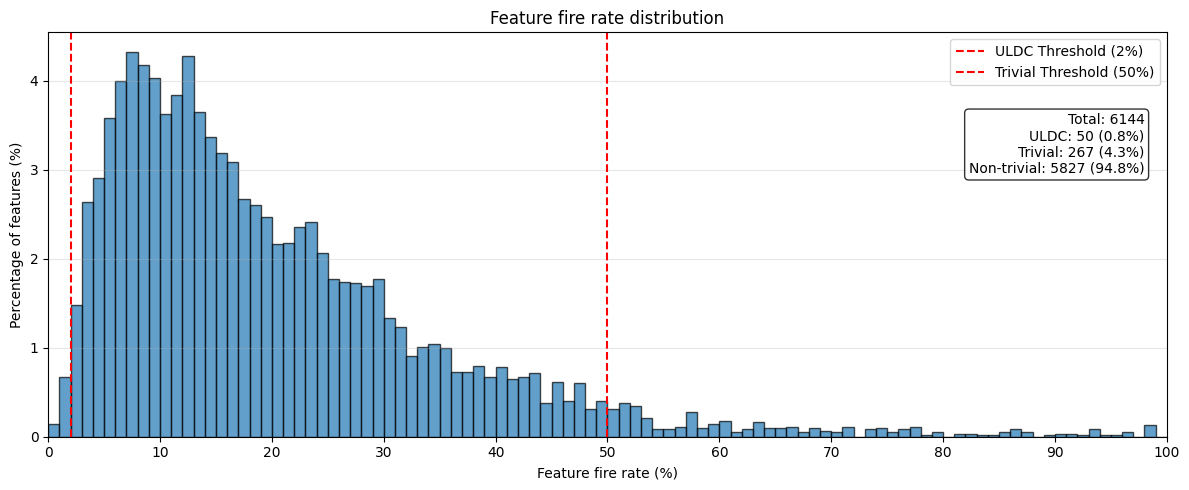

In [9]:
uldc_thresh = 2
trivial_thresh = 50
uldc_features = (feature_activation_pct < uldc_thresh).sum().item()
trivial_features = (feature_activation_pct > trivial_thresh).sum().item()
useful_features = num_features - uldc_features - trivial_features


counts, bins = np.histogram(vals, bins=100, range=(0,100))
counts_pct = (counts / num_features) * 100
bin_width = bins[1] - bins[0]
plt.figure(figsize=(12, 5))
plt.bar(
    bins[:-1],
    counts_pct,
    width=bin_width,
    align='edge',
    edgecolor='black',
    alpha=0.7
)
info_text = f"Total: {num_features}\nULDC: {uldc_features} ({uldc_features/num_features*100:.1f}%)\nTrivial: {trivial_features} ({trivial_features/num_features*100:.1f}%)\nNon-trivial: {useful_features} ({useful_features/num_features*100:.1f}%)"
plt.text(
    0.98, 0.80, info_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
plt.axvline(x=uldc_thresh, color='red', linestyle='--', label=f'ULDC Threshold ({uldc_thresh}%)')
plt.axvline(x=trivial_thresh, color='red', linestyle='--', label=f'Trivial Threshold ({trivial_thresh}%)')
plt.xlabel('Feature fire rate (%)')
plt.ylabel('Percentage of features (%)')
plt.title('Feature fire rate distribution')
plt.grid(axis='y', alpha=0.3)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

In [10]:
for feature_idx in range(config["dict_size"]):
    activation_probability = feature_prob[feature_idx].item()
    top_examples_per_feature[feature_idx] = {
        'feature_id': feature_idx,
        'fire_rate': activation_probability,
        'top_examples': top_examples_per_feature[feature_idx]
    }
file_name = "bert-basse-uncased_layer11_resid-pre_batchtopk"


def save_json():
    serializable_dict = {}
    for feature_idx, feature_data in top_examples_per_feature.items():
        serializable_dict[str(feature_idx)] = {
            'feature_id': feature_data['feature_id'],
            'fire_rate': float(feature_data['fire_rate']),
            'top_examples': feature_data['top_examples']
        }
    with open(f'{file_name}.json', 'w', encoding='utf-8') as f:
        json.dump(serializable_dict, f, ensure_ascii=False, indent=2)

    print(f"Dictionary saved as '{file_name}.json'")

save_json()

with open(f'{file_name}.json', 'r', encoding='utf-8') as f:
    feature_dictionary = json.load(f)
    print(f"Dictionary loaded as '{file_name}.json'")
feature_id = "600"
feature = feature_dictionary[feature_id]
fire_rate = feature['fire_rate']
top_examples = feature['top_examples']

Dictionary saved as 'bert-basse-uncased_layer11_resid-pre_batchtopk.json'
Dictionary loaded as 'bert-basse-uncased_layer11_resid-pre_batchtopk.json'


In [11]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')

In [12]:
import time


def add_embeddings_to_features(feature_dictionary, sbert_model, max_length=128, threshold=76, cooldown=65):
    # Crear una versión modificada del diccionario
    updated_dict = {}

    # Comprobar si podemos monitorizar la temperatura de la GPU
    can_monitor_temp = False
    try:
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        can_monitor_temp = True
    except Exception as e:
        print(f"No se puede monitorizar la temperatura: {e}")

    # Procesar cada feature
    total_features = len(feature_dictionary)
    for idx, (feature_id, feature_data) in enumerate(feature_dictionary.items()):
        # Mostrar progreso
        if idx % 50 == 0:
            print(f"Procesando feature {idx + 1}/{total_features}...")

        # Verificar temperatura si es posible
        if can_monitor_temp:
            try:
                temp = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)
                if temp >= threshold:
                    print(f"⚠️ GPU demasiado caliente ({temp}°C). Esperando hasta que baje a {cooldown}°C...")
                    while True:
                        temp = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)
                        if temp <= cooldown:
                            print(f"Temperatura bajó a {temp}°C, continuando procesamiento...")
                            break
                        time.sleep(5)  # Esperar 5 segundos entre comprobaciones
            except Exception as e:
                print(f"Error al verificar temperatura: {e}")

        # Extraer los ejemplos
        top_examples = feature_data['top_examples']
        updated_examples = []

        # Truncar/hacer padding a los textos
        processed_texts = []
        for act_val, text in top_examples:
            # Truncar si es necesario
            if len(text) > max_length:
                processed_text = text[:max_length]
            else:
                # Hacer padding si es necesario
                padding_needed = max_length - len(text)
                processed_text = text + " " * padding_needed

            processed_texts.append(processed_text)

        # Calcular embeddings en lote para mayor eficiencia
        with torch.no_grad():
            embeddings = sbert_model.encode(processed_texts)

        # Agregar embedding a cada ejemplo
        for i, (act_val, text) in enumerate(top_examples):
            # Convertir numpy array a lista para serialización JSON
            embedding = embeddings[i].tolist()
            # Mantenemos el texto original en el resultado final
            updated_examples.append([act_val, text, embedding])

        # Actualizar el diccionario
        updated_dict[feature_id] = {
            'feature_id': feature_data['feature_id'],
            'fire_rate': feature_data['fire_rate'],
            'top_examples': updated_examples
        }

    # Cerrar pynvml si se inicializó
    if can_monitor_temp:
        try:
            pynvml.nvmlShutdown()
        except:
            pass

    return updated_dict


updated_feature_dictionary = add_embeddings_to_features(feature_dictionary, model, max_length=128)
# Guardar el diccionario actualizado con embeddings
updated_file_name = f"{file_name}_with_embeddings"
with open(f'{updated_file_name}.json', 'w', encoding='utf-8') as f:
    json.dump(updated_feature_dictionary, f, ensure_ascii=False, indent=2)

print(f"Diccionario con embeddings guardado como '{updated_file_name}.json'")

Procesando feature 1/6144...
Procesando feature 51/6144...
Procesando feature 101/6144...
Procesando feature 151/6144...
Procesando feature 201/6144...
Procesando feature 251/6144...
Procesando feature 301/6144...
Procesando feature 351/6144...
Procesando feature 401/6144...
Procesando feature 451/6144...
Procesando feature 501/6144...
Procesando feature 551/6144...
Procesando feature 601/6144...
Procesando feature 651/6144...
Procesando feature 701/6144...
Procesando feature 751/6144...
Procesando feature 801/6144...
Procesando feature 851/6144...
Procesando feature 901/6144...
Procesando feature 951/6144...
Procesando feature 1001/6144...
Procesando feature 1051/6144...
Procesando feature 1101/6144...
Procesando feature 1151/6144...
Procesando feature 1201/6144...
Procesando feature 1251/6144...
Procesando feature 1301/6144...
Procesando feature 1351/6144...
Procesando feature 1401/6144...
Procesando feature 1451/6144...
Procesando feature 1501/6144...
Procesando feature 1551/6144...

In [2]:
def add_feature_embeddings(feature_dictionary):
    """
    Añade un embedding ponderado por activación a cada característica.
    """
    updated_dict = {}
    total_features = len(feature_dictionary)

    for idx, (feature_id, feature_data) in enumerate(feature_dictionary.items()):
        if idx % 500 == 0:
            print(f"Procesando feature {idx + 1}/{total_features}...")

        top_examples = feature_data['top_examples']

        if top_examples and len(top_examples[0]) >= 3:
            # Extraer activaciones y embeddings
            weights = np.array([example[0] for example in top_examples])
            embeddings = np.array([example[2] for example in top_examples])

            # Normalizar pesos para que sumen 1
            weights = weights / np.sum(weights)

            # Calcular embedding ponderado
            weighted_embedding = np.sum(embeddings * weights[:, np.newaxis], axis=0)

            # Normalizar el embedding resultante
            norm = np.linalg.norm(weighted_embedding)
            if norm > 0:
                weighted_embedding = weighted_embedding / norm

            weighted_embedding = weighted_embedding.tolist()
        else:
            weighted_embedding = np.zeros(768).tolist()  # Dimensión de SBERT

        updated_dict[feature_id] = {
            **feature_data,  # Mantener todos los campos originales
            'feature_embedding': weighted_embedding  # Añadir el nuevo campo
        }

    return updated_dict

# Cargar el diccionario existente
with open('bert-base-uncased_layer11_resid-pre_batchtopk_with_embeddings.json', 'r', encoding='utf-8') as f:
    feature_dict = json.load(f)

# Añadir embeddings ponderados
updated_dict = add_feature_embeddings(feature_dict)

# Guardar el resultado
with open('bert-base-uncased_layer11_resid-pre_batchtopk_with_feature_embeddings.json', 'w', encoding='utf-8') as f:
    json.dump(updated_dict, f, ensure_ascii=False)

Procesando feature 1/6144...
Procesando feature 501/6144...
Procesando feature 1001/6144...
Procesando feature 1501/6144...
Procesando feature 2001/6144...
Procesando feature 2501/6144...
Procesando feature 3001/6144...
Procesando feature 3501/6144...
Procesando feature 4001/6144...
Procesando feature 4501/6144...
Procesando feature 5001/6144...
Procesando feature 5501/6144...
Procesando feature 6001/6144...


In [ ]:
with open('bert-base-uncased_layer11_resid-pre_batchtopk_with_feature_embeddings.json', 'r', encoding='utf-8') as f:
    feature_dictionary_bert = json.load(f)

In [19]:
num_feats = 6144
embed_dim = 768
config = get_default_cfg()

features = np.zeros((num_feats, embed_dim), dtype=np.float32)
for feature_id, feature_data in feature_dictionary_bert.items():
    idx = int(feature_id)
    if 'feature_embedding' in feature_data:
        features[idx] = feature_data['feature_embedding']
    else:
        print(f"La característica {feature_id} no tiene 'feature_embedding'")
features_tensor_bert = torch.tensor(features, dtype=torch.float32).to(config["device"])

Procesado hasta 256/6144 características
Procesado hasta 512/6144 características
Procesado hasta 768/6144 características
Procesado hasta 1024/6144 características
Procesado hasta 1280/6144 características
Procesado hasta 1536/6144 características
Procesado hasta 1792/6144 características
Procesado hasta 2048/6144 características
Procesado hasta 2304/6144 características
Procesado hasta 2560/6144 características
Procesado hasta 2816/6144 características
Procesado hasta 3072/6144 características
Procesado hasta 3328/6144 características
Procesado hasta 3584/6144 características
Procesado hasta 3840/6144 características
Procesado hasta 4096/6144 características
Procesado hasta 4352/6144 características
Procesado hasta 4608/6144 características
Procesado hasta 4864/6144 características
Procesado hasta 5120/6144 características
Procesado hasta 5376/6144 características
Procesado hasta 5632/6144 características
Procesado hasta 5888/6144 características
Procesado hasta 6144/6144 característ

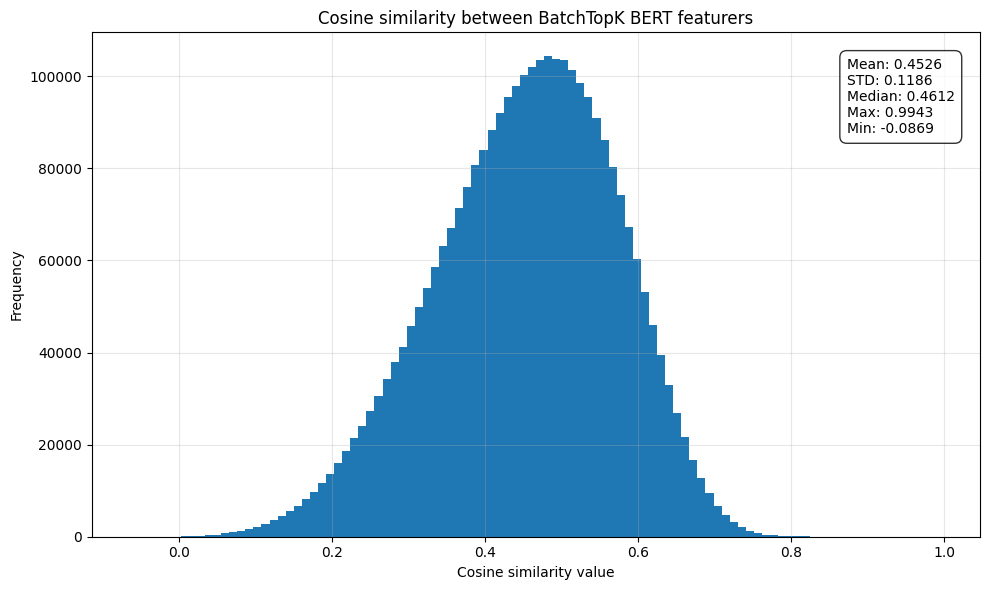

In [20]:
def compute_cosine_similarity_in_batches(features, batch_size=256):
    n_features = features.shape[0]
    normalized_features = F.normalize(features, p=2, dim=1)

    max_sim = -1.0
    min_sim = 1.0
    sim_values_list = []

    for i in range(0, n_features, batch_size):
        end_i = min(i + batch_size, n_features)
        batch_i = normalized_features[i:end_i]

        for j in range(0, n_features, batch_size):
            end_j = min(j + batch_size, n_features)
            batch_j = normalized_features[j:end_j]

            sim_batch = torch.mm(batch_i, batch_j.transpose(0, 1))

            if i == j:
                mask = torch.ones_like(sim_batch, dtype=torch.bool).triu(diagonal=1)
                values = sim_batch[mask]
            elif i < j:
                values = sim_batch.flatten()
            else:
                continue

            if len(values) > 0:
                curr_max = torch.max(values).item()
                curr_min = torch.min(values).item()
                max_sim = max(max_sim, curr_max)
                min_sim = min(min_sim, curr_min)

                if len(values) > 10000:
                    indices = torch.randperm(len(values))[:10000]
                    sampled_values = values[indices].cpu().numpy()
                else:
                    sampled_values = values.cpu().numpy()

                sim_values_list.append(sampled_values)

        print(f"Procesado hasta {end_i}/{n_features} características")

    all_sim_values = np.concatenate(sim_values_list)
    avg_sim = all_sim_values.mean()
    std_sim = all_sim_values.std()
    median_sim = np.median(all_sim_values)

    return {
        "max_sim": max_sim,
        "min_sim": min_sim,
        "avg_sim": avg_sim,
        "std_sim": std_sim,
        "median_sim": median_sim,
        "sim_values": all_sim_values
    }

# Ejecutar el cálculo por lotes
similarity_stats = compute_cosine_similarity_in_batches(features_tensor_bert, batch_size=256)

# Mostrar estadísticas
print(f"Valor máximo: {similarity_stats['max_sim']:.4f}")
print(f"Valor mínimo: {similarity_stats['min_sim']:.4f}")
print(f"Valor promedio: {similarity_stats['avg_sim']:.4f}")
print(f"Desviación estándar: {similarity_stats['std_sim']:.4f}")
print(f"Mediana: {similarity_stats['median_sim']:.4f}")

# Visualizar distribución con recuadro de estadísticas
plt.figure(figsize=(10, 6))
plt.hist(similarity_stats['sim_values'], bins=100)
plt.title('Cosine similarity between BatchTopK BERT featurers')
plt.xlabel('Cosine similarity value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

# Crear recuadro con estadísticas
stats_text = f"Mean: {similarity_stats['avg_sim']:.4f}\n" \
             f"STD: {similarity_stats['std_sim']:.4f}\n" \
             f"Median: {similarity_stats['median_sim']:.4f}\n" \
             f"Max: {similarity_stats['max_sim']:.4f}\n" \
             f"Min: {similarity_stats['min_sim']:.4f}"

plt.text(0.85, 0.95, stats_text, transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8),
         fontsize=10, verticalalignment="top")

plt.tight_layout()
plt.show()

In [3]:
def add_feature_embeddings(feature_dictionary):
    """
    Añade un embedding ponderado por activación a cada característica.
    """
    updated_dict = {}
    total_features = len(feature_dictionary)

    for idx, (feature_id, feature_data) in enumerate(feature_dictionary.items()):
        if idx % 500 == 0:
            print(f"Procesando feature {idx + 1}/{total_features}...")

        top_examples = feature_data['top_examples']

        if top_examples and len(top_examples[0]) >= 3:
            # Extraer activaciones y embeddings
            weights = np.array([example[0] for example in top_examples])
            embeddings = np.array([example[2] for example in top_examples])

            # Normalizar pesos para que sumen 1
            weights = weights / np.sum(weights)

            # Calcular embedding ponderado
            weighted_embedding = np.sum(embeddings * weights[:, np.newaxis], axis=0)

            # Normalizar el embedding resultante
            norm = np.linalg.norm(weighted_embedding)
            if norm > 0:
                weighted_embedding = weighted_embedding / norm

            weighted_embedding = weighted_embedding.tolist()
        else:
            weighted_embedding = np.zeros(768).tolist()  # Dimensión de SBERT

        updated_dict[feature_id] = {
            **feature_data,  # Mantener todos los campos originales
            'feature_embedding': weighted_embedding  # Añadir el nuevo campo
        }

    return updated_dict

# Cargar el diccionario existente
with open('gpt2-small_layer11_resid-pre_batchtopk_with_embeddings.json', 'r', encoding='utf-8') as f:
    feature_dict = json.load(f)

# Añadir embeddings ponderados
updated_dict = add_feature_embeddings(feature_dict)

# Guardar el resultado
with open('gpt2-small_layer11_resid-pre_batchtopk_with_feature_embeddings.json', 'w', encoding='utf-8') as f:
    json.dump(updated_dict, f, ensure_ascii=False)

Procesando feature 1/6144...
Procesando feature 501/6144...
Procesando feature 1001/6144...
Procesando feature 1501/6144...
Procesando feature 2001/6144...
Procesando feature 2501/6144...
Procesando feature 3001/6144...
Procesando feature 3501/6144...
Procesando feature 4001/6144...
Procesando feature 4501/6144...
Procesando feature 5001/6144...
Procesando feature 5501/6144...
Procesando feature 6001/6144...


In [ ]:
with open('gpt2-smal_layer11_resid-pre_batchtopk_with_feature_embeddings.json', 'r', encoding='utf-8') as f:
    feature_dictionary_gpt2 = json.load(f)
num_feats = 6144
embed_dim = 768
config = get_default_cfg()

features = np.zeros((num_feats, embed_dim), dtype=np.float32)
for feature_id, feature_data in feature_dictionary_bert.items():
    idx = int(feature_id)
    if 'feature_embedding' in feature_data:
        features[idx] = feature_data['feature_embedding']
    else:
        print(f"La característica {feature_id} no tiene 'feature_embedding'")
features_tensor_gpt2 = torch.tensor(features, dtype=torch.float32).to(config["device"])

In [ ]:
def encontrar_similitudes_entre_modelos(features_bert, features_gpt2, batch_size=256, umbral=0.8):
    """
    Encuentra vectores similares entre features_bert y features_gpt2 usando similitud coseno.

    Args:
        features_bert: Tensor de forma [n_features_bert, embed_dim]
        features_gpt2: Tensor de forma [n_features_gpt2, embed_dim]
        batch_size: Tamaño del lote para procesamiento
        umbral: Umbral mínimo de similitud coseno para considerar características como similares

    Returns:
        Lista de tuplas (id_feature_bert, id_feature_gpt2, valor_similitud)
    """
    n_features_bert = features_bert.shape[0]
    n_features_gpt2 = features_gpt2.shape[0]

    # Normalizar vectores para cálculo de similitud coseno
    normalized_bert = F.normalize(features_bert, p=2, dim=1)
    normalized_gpt2 = F.normalize(features_gpt2, p=2, dim=1)

    # Lista para almacenar pares similares
    pares_similares = []

    # Para cada lote de características de BERT
    for i in range(0, n_features_bert, batch_size):
        end_i = min(i + batch_size, n_features_bert)
        batch_bert = normalized_bert[i:end_i]

        # Para cada lote de características de GPT-2
        for j in range(0, n_features_gpt2, batch_size):
            end_j = min(j + batch_size, n_features_gpt2)
            batch_gpt2 = normalized_gpt2[j:end_j]

            # Calcular matriz de similitud para el lote actual
            sim_batch = torch.mm(batch_bert, batch_gpt2.transpose(0, 1))

            # Encontrar pares con alta similitud
            pares_alto_sim = (sim_batch >= umbral).nonzero(as_tuple=True)

            if len(pares_alto_sim[0]) > 0:
                for idx_rel, idx_abs in enumerate(pares_alto_sim[0]):
                    feature_bert_id = i + idx_abs.item()
                    feature_gpt2_id = j + pares_alto_sim[1][idx_rel].item()
                    sim_valor = sim_batch[idx_abs, pares_alto_sim[1][idx_rel]].item()
                    pares_similares.append((feature_bert_id, feature_gpt2_id, sim_valor))

        # Mostrar progreso
        print(f"Procesado hasta {end_i}/{n_features_bert} características de BERT")

    # Ordenar por similitud de mayor a menor
    pares_similares.sort(key=lambda x: x[2], reverse=True)

    return pares_similares

# Calcular las similitudes entre los modelos
umbral_similitud = 0.7  # Puedes ajustar este valor según necesites
similitudes = encontrar_similitudes_entre_modelos(
    features_tensor_bert,
    features_tensor_gpt2,
    batch_size=256,
    umbral=umbral_similitud
)

# Mostrar resultados
print(f"Total de pares similares encontrados: {len(similitudes)}")
print("\nLos 20 pares más similares:")
for bert_id, gpt2_id, sim in similitudes[:20]:
    print(f"BERT feature {bert_id} ↔ GPT-2 feature {gpt2_id}: similitud = {sim:.4f}")

# Visualizar distribución de similitudes
if similitudes:
    sim_values = [s for _, _, s in similitudes]

    plt.figure(figsize=(10, 6))
    plt.hist(sim_values, bins=50)
    plt.title('Distribución de similitud coseno entre características de BERT y GPT-2')
    plt.xlabel('Similitud coseno')
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3)

    # Añadir estadísticas en un recuadro
    media = np.mean(sim_values)
    desv_std = np.std(sim_values)
    mediana = np.median(sim_values)

    stats_text = f"Media: {media:.4f}\n" \
                f"Desv. Est.: {desv_std:.4f}\n" \
                f"Mediana: {mediana:.4f}\n" \
                f"Total pares: {len(similitudes)}"

    plt.text(0.02, 0.95, stats_text, transform=plt.gca().transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8),
            fontsize=10, verticalalignment="top")

    plt.tight_layout()
    plt.show()